In [1]:
import pandas as pd
import numpy as np
import geojson
from datetime import datetime, time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [18]:
# To remove pandas warnings - ref (https://stackoverflow.com/a/20627316)
pd.options.mode.chained_assignment = None  # default='warn'

References:

- _Stack Overflow_ :
    - https://stackoverflow.com/questions/50375985/pandas-add-column-with-value-based-on-condition-based-on-other-columns
    - https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    - https://stackoverflow.com/questions/44111307/python-pandas-count-rows-based-on-column
    - https://stackoverflow.com/questions/47502891/removing-group-header-after-pandas-aggregation
    - https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns

- _Others_ :
    - https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
    - https://datatofish.com/line-chart-python-matplotlib/
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    - https://github.com/rahulrohri/final_project_2020Sp
    - https://studio.mapbox.com/
    - https://plotly.com/python/scattermapbox/
    - https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90
    - https://plotly.com/python/mapbox-county-choropleth/
    - https://medium.com/@ingeh/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

In [69]:
NYC_collision_crashes_file = "Motor_Vehicle_Collisions_-_Crashes.csv"
NYC_collision_persons_file = "Motor_Vehicle_Collisions_-_Person.csv"
Population_by_age_2010 = 'population_by_age_2010.csv'
Zipcode_geojson = 'zipcode.geojson'

In [3]:
def load_collision_data(crashes_file, persons_file):
    crashes = pd.read_csv(crashes_file, low_memory=False)
    persons = pd.read_csv(persons_file, low_memory=False)
    
    crashes.loc[:, 'CRASH_YEAR'] = crashes['CRASH DATE'].astype(np.str_).apply(lambda x: int(x.split('/')[-1]))
    
    return crashes, persons

In [4]:
crashes, persons = load_collision_data(NYC_collision_crashes_file, NYC_collision_persons_file)

In [5]:
crashes.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'CRASH_YEAR'],
      dtype='object')

In [6]:
persons.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

## Hypothesis:
#### Of all collisions occurring late in the night (between 12 am - 5 am), the majority are caused due to an unsafe vehicle speed.

In [7]:
def get_night_crashes(crashes):
    
    time_data = crashes['CRASH TIME']
    crashes['CRASH TIME'] = crashes['CRASH TIME'].apply(lambda x: datetime.strptime(x, "%H:%M").time())

    night_crash_data = crashes[(crashes['CRASH TIME'] < time(5, 0, 0))]

    return night_crash_data

In [8]:
def check_for_unsafe_speed(night_crash_data):
    night_crash_data = night_crash_data.assign(hasUnsafeSpeed=False)
    night_crash_data.loc[((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5']=='Unsafe Speed')), 
                         'hasUnsafeSpeed'] = True
    
    return night_crash_data

In [9]:
def calculate_percentage_of_speedy_collisions(night_crash_data):
    unsafe_speed_metrics = night_crash_data['hasUnsafeSpeed'].value_counts().to_frame()
    percentage_unsafe_speed_collisions = unsafe_speed_metrics.iloc[1]*100/night_crash_data.shape[0]
    
    return percentage_unsafe_speed_collisions

In [10]:
def calculate_invalid_collision_percentage(night_crash_data):
    
    unwanted_contributing_factors = ['1','80','Unspecified']
    
    night_crash_data.loc[:, 'isUnspecified'] = np.where((((
        night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isin(unwanted_contributing_factors)) | 
        (night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isin(unwanted_contributing_factors)) | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull()))), True, False)
    
    invalid_night_crash_data_metrics = night_crash_data['isUnspecified'].value_counts().to_frame()
    
    percentage_invalid_collision_data = invalid_night_crash_data_metrics.iloc[1]*100/night_crash_data.shape[0]
    
    return percentage_invalid_collision_data

In [11]:
night_crash_data = get_night_crashes(crashes)

In [12]:
night_crash_data.head()

CRASH DATE CRASH TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
11  06/16/2018   00:05:00  MANHATTAN    10002  40.719970 -73.992905   
12  06/19/2018   01:00:00     QUEENS    11377  40.758960 -73.898384   
18  06/15/2018   00:52:00        NaN      NaN  40.780125 -73.953040   
25  06/04/2018   00:53:00   BROOKLYN    11238  40.673290 -73.957030   
54  06/26/2018   01:50:00     QUEENS    11101  40.748943 -73.954110   

                  LOCATION                    ON STREET NAME  \
11  (40.71997, -73.992905)  DELANCEY STREET                    
12  (40.75896, -73.898384)                               NaN   
18  (40.780125, -73.95304)  3 AVENUE                           
25   (40.67329, -73.95703)  STERLING PLACE                     
54  (40.748943, -73.95411)                               NaN   

   CROSS STREET NAME                           OFF STREET NAME  ...  \
11   CHRYSTIE STREET                                       NaN  ...   
12               NaN  30-46     69 STREET                       ...   
18               NaN                                       NaN  ...   
25   FRANKLIN AVENUE                                       NaN  ...   
54               NaN  5-26      45 AVENUE                       ...   

    CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
11                            NaN                            NaN   
12                            NaN                            NaN   
18                            NaN                            NaN   
25                            NaN                            NaN   
54                            NaN                            NaN   

    CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
11                            NaN       3922402   
12                            NaN       3926636   
18                            NaN       3924614   
25                            NaN       3915438   
54                            NaN       3929104   

                    VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
11  Station Wagon/Sport Utility Vehicle  Station Wagon/Sport Utility Vehicle   
12                                Sedan                                Sedan   
18                                 Bike                                 Taxi   
25                                Sedan                                Sedan   
54                        Armored Truck                                Sedan   

    VEHICLE TYPE CODE 3  VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5 CRASH_YEAR  
11                  NaN                  NaN                 NaN       2018  
12                  NaN                  NaN                 NaN       2018  
18                  NaN                  NaN                 NaN       2018  
25                  NaN                  NaN                 NaN       2018  
54                  NaN                  NaN                 NaN       2018  

[5 rows x 30 columns]

In [13]:
night_crash_unsafe_speed_data = check_for_unsafe_speed(night_crash_data)

In [16]:
percentage_unsafe_speed_collisions = calculate_percentage_of_speedy_collisions(night_crash_unsafe_speed_data)
percentage_unsafe_speed_collisions

hasUnsafeSpeed    2.687928
Name: True, dtype: float64

In [19]:
percentage_invalid_collision_data = calculate_invalid_collision_percentage(night_crash_data)
percentage_invalid_collision_data

isUnspecified    34.79346
Name: True, dtype: float64

## Hypothesis:

#### Of all crashes, a majority number is caused by persons between the age of 16-25.

In [20]:
def get_merged_crashes_persons(crashes, persons):
    crashes_persons = pd.merge(crashes, persons, left_on='COLLISION_ID', right_on='COLLISION_ID', how='inner')
    crashes_persons.loc[:, 'CRASH_YEAR'] = crashes_persons['CRASH_DATE'].astype(np.str_).apply(lambda x: x.split('/')[-1])
    del crashes_persons['CRASH_DATE']
    del crashes_persons['CRASH_TIME']
    del crashes_persons['UNIQUE_ID']
    return crashes_persons

In [21]:
def get_crashes_persons_age_grouping_data(crashes_persons, columns):
    crashes_persons_age_grouping = crashes_persons[crashes_persons['POSITION_IN_VEHICLE'] == 'Driver'][columns]
    crashes_persons_age_grouping.loc[:, 'age16-25'] = np.where((crashes_persons_age_grouping['PERSON_AGE'] > 15) & 
                                                               (crashes_persons_age_grouping['PERSON_AGE'] < 26), True, False)
    return crashes_persons_age_grouping

In [22]:
def get_population_proportion_data(filename):
    population_by_age_2010 = pd.read_csv(filename)
    ages = [str(i) for i in range(16, 26)]
    population_by_age_2010.loc[:, 'age16-25'] = np.where(population_by_age_2010['age'].isin(ages), True, False)
    population_by_age_2010.loc[:, 'proportion'] = population_by_age_2010['population'] / population_by_age_2010['population'].sum()
    return population_by_age_2010

In [42]:
def get_grouped_crashes_age_group_data(crashes_persons_age_grouping, pop_prop_16_25, pop_prop_26_99):
    crashes_by_year_age = crashes_persons_age_grouping.groupby(['CRASH_YEAR', 'PERSON_AGE']).size().reset_index()
    crashes_by_year_age = crashes_by_year_age.rename(columns={0: 'crashes'})
    crashes_by_year_age.loc[:, 'age_group'] = np.where((crashes_by_year_age['PERSON_AGE'] > 15) & 
                                                  (crashes_by_year_age['PERSON_AGE'] < 26), '16-25', '26-99')
    
    crashes_by_year_age_grouped = crashes_by_year_age.groupby(['CRASH_YEAR', 'age_group']).agg({'crashes': ['sum']}).reset_index()
    crashes_by_year_age_grouped.columns = crashes_by_year_age_grouped.columns.droplevel(1)
    crashes_by_year_age_grouped = crashes_by_year_age_grouped.pivot(index='CRASH_YEAR', columns='age_group', values='crashes')
    crashes_by_year_age_grouped.loc[:, 'total'] = crashes_by_year_age_grouped['26-99'] + crashes_by_year_age_grouped['16-25']
    crashes_by_year_age_grouped.loc[:, 'norm_16-25'] = (crashes_by_year_age_grouped['16-25'] * 100) / (crashes_by_year_age_grouped['total'].sum() * pop_prop_16_25)
    crashes_by_year_age_grouped.loc[:, 'norm_26-99'] = (crashes_by_year_age_grouped['26-99'] * 100) / (crashes_by_year_age_grouped['total'].sum() * pop_prop_26_99)
    
    return crashes_by_year_age_grouped.reset_index()

In [45]:
def plot_crashes_age_groups(crashes_by_year_age_grouped):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_16-25'].tolist(),
        name="Normalized number of crashes for age group 16-25"
    ))


    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_26-99'].tolist(),
        name="Normalized number of crashes for age group 26-99"
    ))

    fig.update_layout(
        title="Plot of normalized number of crashes per year for age groups 16-25 and 26-99 for every 100 people",
        xaxis_title="Year",
        yaxis_title="Normalized number of crashes",
        legend_title="Legend"
    )

    fig.show()

In [25]:
crashes_persons = get_merged_crashes_persons(crashes, persons)

In [26]:
crashes_persons['PERSON_TYPE'].unique()

array(['Occupant', 'Pedestrian', 'Bicyclist'], dtype=object)

In [27]:
# check if there are entries where person is of 'Bicyclist' type and vehicle id is None
crashes_persons[(crashes_persons['VEHICLE_ID'].isna()) & 
                (crashes_persons['PERSON_TYPE'] == 'Bicyclist')][['COLLISION_ID', 'PERSON_TYPE', 'POSITION_IN_VEHICLE']]

Empty DataFrame
Columns: [COLLISION_ID, PERSON_TYPE, POSITION_IN_VEHICLE]
Index: []

In [28]:
# dropping all rows where there is no vehicle ID present
crashes_persons.drop(crashes_persons.loc[crashes_persons['VEHICLE_ID'].isna()].index, inplace=True)

In [29]:
columns = ['CRASH_YEAR', 'PERSON_AGE']
crashes_persons_age_grouping = get_crashes_persons_age_grouping_data(crashes_persons, columns)

In [30]:
crashes_persons_age_grouping.head()

CRASH_YEAR  PERSON_AGE  age16-25
1       2018        57.0     False
5       2018        38.0     False
6       2018        39.0     False
8       2018        43.0     False
9       2018        83.0     False

In [32]:
crashes_persons_age_grouping.loc[:, 'ageBelow16'] = np.where(crashes_persons_age_grouping['PERSON_AGE'] < 16, True, False)
crashes_persons_age_grouping['ageBelow16'].value_counts()

False    1465016
True        8528
Name: ageBelow16, dtype: int64

In [33]:
crashes_persons_age_grouping.loc[:, 'ageAbove99'] = np.where(crashes_persons_age_grouping['PERSON_AGE'] > 99, True, False)
crashes_persons_age_grouping['ageAbove99'].value_counts()

False    1472186
True        1358
Name: ageAbove99, dtype: int64

In [34]:
crashes_persons_age_grouping['PERSON_AGE'].isna().sum()

5066

In [35]:
# Dropping all rows with age < 16, age > 99 and age Nan
crashes_persons_age_grouping.drop(
    crashes_persons_age_grouping.loc[(crashes_persons_age_grouping['ageBelow16']) | 
                                     (crashes_persons_age_grouping['ageAbove99']) | 
                                     (crashes_persons_age_grouping['PERSON_AGE'].isna())].index, inplace=True)

Using the 2010 population by age demographics of NYC for getting the population proportions by age

In [36]:
population_by_age_2010 = get_population_proportion_data(Population_by_age_2010)

In [37]:
# Proportion of population for the age group 16-25
pop_prop_16_25 = population_by_age_2010[population_by_age_2010['age16-25']]['proportion'].sum()
pop_prop_16_25

0.15003046433617656

In [38]:
# Proportion of population for the age group 26-99
ages = [str(i) for i in range(26, 100)]
pop_prop_26_99 = population_by_age_2010[population_by_age_2010['age'].isin(ages)]['proportion'].sum()
pop_prop_26_99

0.6589243257571468

In [43]:
crashes_by_year_age_grouped = get_grouped_crashes_age_group_data(crashes_persons_age_grouping, pop_prop_16_25, pop_prop_26_99)
crashes_by_year_age_grouped

age_group CRASH_YEAR  16-25   26-99   total  norm_16-25  norm_26-99
0               2012     12      19      31    0.005484    0.001977
1               2013     11      50      61    0.005027    0.005202
2               2014     30     124     154    0.013709    0.012902
3               2015     45     174     219    0.020564    0.018104
4               2016  41268  245473  286741   18.858196   25.540792
5               2017  50792  305532  356324   23.210368   31.789766
6               2018  49200  308564  357764   22.482874   32.105238
7               2019  44203  279581  323784   20.199400   29.089636
8               2020  21468  112046  133514    9.810210   11.658079

In [46]:
plot_crashes_age_groups(crashes_by_year_age_grouped)

## Hypothesis

#### The number of collisions increased with an increase in population

Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

In [47]:
def get_NYC_population_data():
    #Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population
    
    NYC_Population_data = {'Year':  [2012,2013,2014,2015,2016,2017,2018,2019,2020],
        'Population': [8348030,8398740,8437390,8468180,8475980,8438270, 8398750, 8361040, 8323340]
        }

    NYC_Population = pd.DataFrame (NYC_Population_data, columns = ['Year','Population'])
    
    NYC_area = 300.4 #(in sq miles) Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population
    
    NYC_Population.loc[:,'Population_Density'] = NYC_Population['Population'].apply(lambda x: x/NYC_area)
    
    return NYC_Population

In [48]:
def get_total_crashes_per_year(crashes):
    crashes_data = crashes.copy()
    crashes_total = crashes_data.groupby(['CRASH_YEAR'], sort=False).size().reset_index(name='Total_Crashes')
    crashes_total['CRASH_YEAR'] = crashes_total['CRASH_YEAR'].astype('int64')
    
    crashes_total = crashes_total.sort_values(by=['CRASH_YEAR'])
    
    return crashes_total

In [49]:
def calculate_crashes_per_capita(crashes_total, NYC_Population):
    crashes_population = pd.merge(crashes_total, NYC_Population, left_on='CRASH_YEAR', right_on='Year', how='inner')
    
    crashes_population.loc[:, 'Crashes_per_capita'] = crashes_population['Total_Crashes']/crashes_population['Population']
    
    return crashes_population

In [50]:
def plot_crashes_per_capita_vs_year(crashes_population):
    plt.plot(crashes_population['Year'], crashes_population['Crashes_per_capita'], color='red', marker='o')
    plt.title('Crashes_per_Capita Vs Year for NYC')
    plt.xlabel('Year')
    plt.ylabel('Crashes_per_capita')
    plt.show()

In [64]:
def plot_crashes_per_capita_vs_population_density(crashes_population):
    plt.plot(crashes_population['Crashes_per_capita'], crashes_population['Population_Density'], color='red', marker='o')
    plt.title('Crashes_per_Capita Vs Population for NYC')
    plt.ylabel('Population Density (per sq mi.)')
    plt.xlabel('Crashes_per_capita')
    plt.show()

In [52]:
NYC_Population = get_NYC_population_data()
NYC_Population.head()

Year  Population  Population_Density
0  2012     8348030        27789.713715
1  2013     8398740        27958.521971
2  2014     8437390        28087.183755
3  2015     8468180        28189.680426
4  2016     8475980        28215.645806

In [61]:
crashes_total = get_total_crashes_per_year(crashes)
crashes_total

CRASH_YEAR  Total_Crashes
4        2012         100541
8        2013         203734
7        2014         206033
6        2015         217694
5        2016         229830
1        2017         231007
0        2018         231562
2        2019         211481
3        2020          99840

In [60]:
crashes_population = calculate_crashes_per_capita(crashes_total, NYC_Population)
crashes_population

CRASH_YEAR  Total_Crashes  Year  Population  Population_Density  \
0        2012         100541  2012     8348030        27789.713715   
1        2013         203734  2013     8398740        27958.521971   
2        2014         206033  2014     8437390        28087.183755   
3        2015         217694  2015     8468180        28189.680426   
4        2016         229830  2016     8475980        28215.645806   
5        2017         231007  2017     8438270        28090.113182   
6        2018         231562  2018     8398750        27958.555260   
7        2019         211481  2019     8361040        27833.022636   
8        2020          99840  2020     8323340        27707.523302   

   Crashes_per_capita  
0            0.012044  
1            0.024258  
2            0.024419  
3            0.025707  
4            0.027115  
5            0.027376  
6            0.027571  
7            0.025294  
8            0.011995

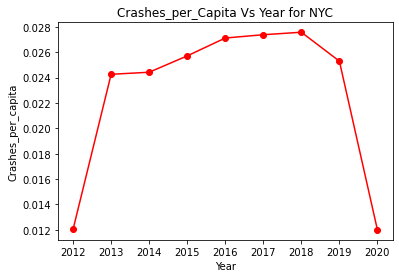

In [55]:
plot_crashes_per_capita_vs_year(crashes_population)

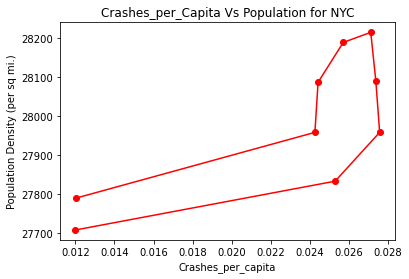

In [65]:
plot_crashes_per_capita_vs_population_density(crashes_population)

In [57]:
crashes_population_subset = crashes_population.drop([0,8],0)

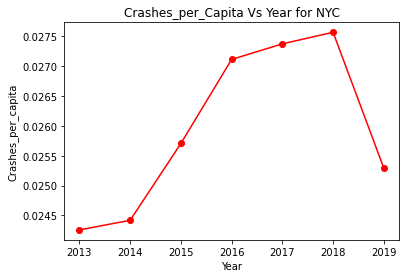

In [58]:
plot_crashes_per_capita_vs_year(crashes_population_subset)

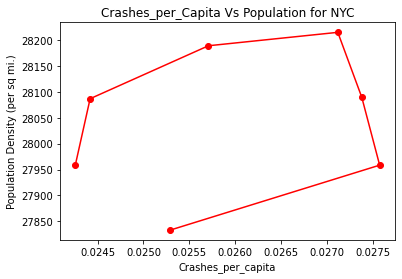

In [66]:
plot_crashes_per_capita_vs_population_density(crashes_population_subset)

## Additional Observations

In [76]:
def set_up_crashes_for_map(crashes, geojson_filename, year=0):
    if year == 0:
        df = crashes
    else:
        df = crashes[crashes['CRASH_YEAR'] == year]
    with open(geojson_filename) as f:
        gj = geojson.load(f)
        for feature in gj['features']:
            zipcode = feature['properties']['postalCode']
            feature['id'] = zipcode

    crashes_per_zipcode = df.groupby(['ZIP CODE'], sort=True).size().reset_index(name='crashes_per_zipcode')
    crashes_per_zipcode = crashes_per_zipcode.rename(columns={'ZIP CODE': 'zipcode'})
    crashes_per_zipcode.drop(crashes_per_zipcode[(crashes_per_zipcode['zipcode'].isna()) |
                                                 (crashes_per_zipcode['zipcode'] == "     ")].index, inplace=True)
    return crashes_per_zipcode, gj

In [94]:
def plot_crash_locations(crashes_per_zipcode, gj):

    fig = px.choropleth_mapbox(crashes_per_zipcode, geojson=gj, locations='zipcode', color='crashes_per_zipcode',
                               color_continuous_scale="Viridis",
                               range_color=(0, 2500),
                               mapbox_style="carto-positron",
                               zoom=9, center={"lat": 40.74, "lon": -73.8},
                               opacity=0.5
                               )
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()

In [98]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2015)
plot_crash_locations(crashes_per_zipcode, gj)

In [99]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2016)
plot_crash_locations(crashes_per_zipcode, gj)

In [100]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2017)
plot_crash_locations(crashes_per_zipcode, gj)

In [101]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2018)
plot_crash_locations(crashes_per_zipcode, gj)

In [102]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson, 2019)
plot_crash_locations(crashes_per_zipcode, gj)